In [6]:
library(readr)

d <- read_table2(
  file = "data/m-ibm3dx2608.txt",
  col_types = cols(
    .default = col_double(),
    date = col_date(format = "%Y%m%d")
  )
)

In [ ]:
library(xts)
library(zoo)

# Convert data frame to xts object, remove the first column (date)
ibmind <- xts(as.matrix(d[, -1]), order.by = d$date)
rm(d)

# Set time class to 'yearmon'
tclass(ibmind) <- "yearmon"

# Extract 'ewrtn' column as a time series
ew <- ts(coredata(ibmind)[, "ewrtn"], start = c(1926, 1), frequency = 12)

# Display the first few rows
head(ibmind)

# ibmrtn     vwrtn     ewrtn     sprtn
# Jan 1926 -0.010381  0.000724  0.023174  0.022472
# Feb 1926 -0.024476 -0.033374 -0.053510 -0.043956
# Mar 1926 -0.115591 -0.064341 -0.096824 -0.059113
# Apr 1926  0.089783  0.038358  0.032946  0.022688
# May 1926  0.036932  0.012172  0.001035  0.007679
# Jun 1926  0.068493  0.056888  0.050487  0.043184

            ibmrtn     vwrtn     ewrtn     sprtn
Jan 1926 -0.010381  0.000724  0.023174  0.022472
Feb 1926 -0.024476 -0.033374 -0.053510 -0.043956
Mar 1926 -0.115591 -0.064341 -0.096824 -0.059113
Apr 1926  0.089783  0.038358  0.032946  0.022688
May 1926  0.036932  0.012172  0.001035  0.007679
Jun 1926  0.068493  0.056888  0.050487  0.043184

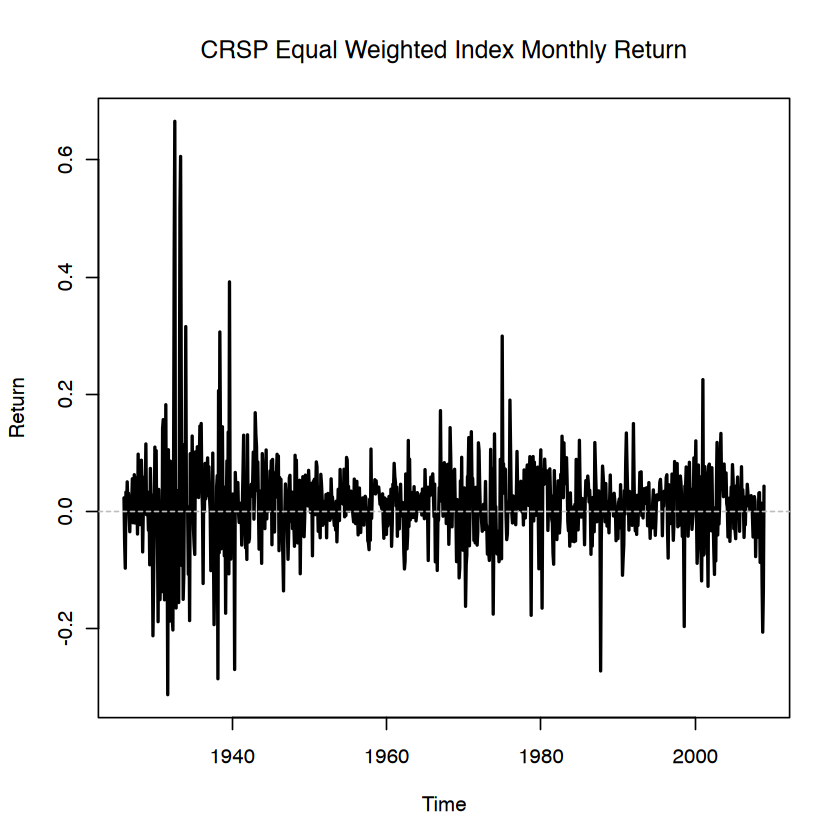

In [10]:
plot(
  ew,
  main = "CRSP Equal Weighted Index Monthly Return",
  ylab = "Return",
  xlab = "Time",
  lwd = 2
)
abline(h = 0, col = "gray", lty = 2)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



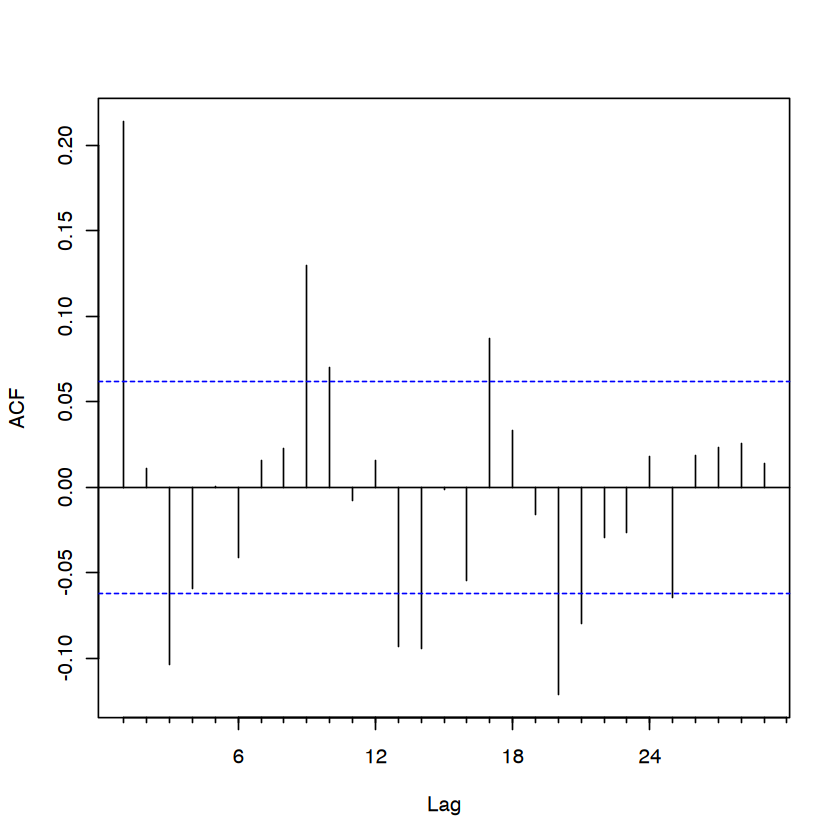

In [11]:
forecast::Acf(ew, main = "")

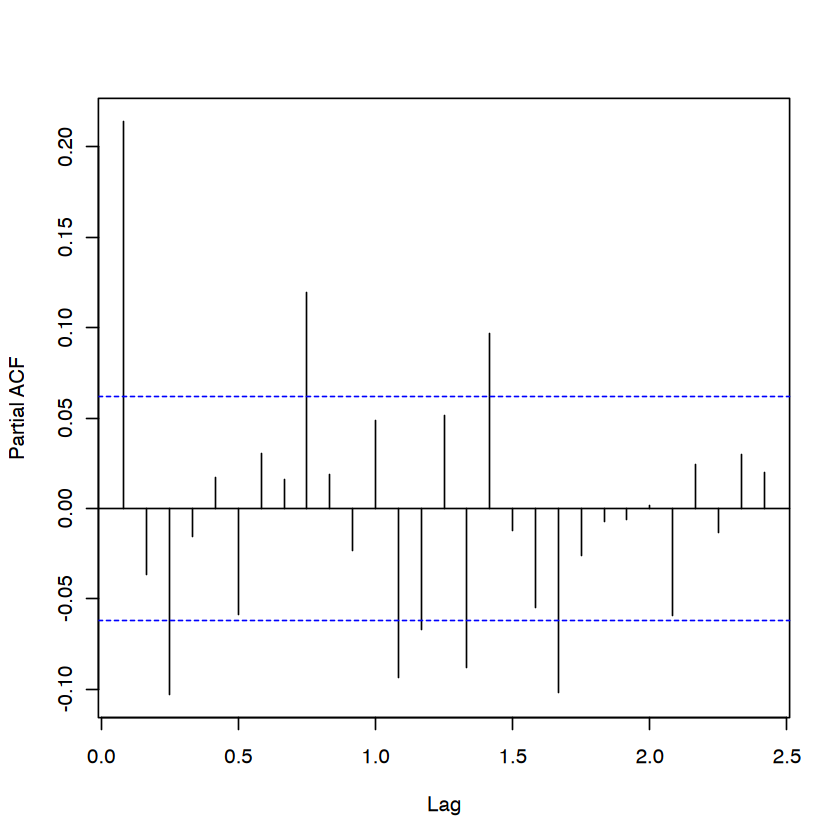

In [12]:
pacf(ew, main = "")

In [ ]:
resm1 <- arima(ew, order = c(0, 0, 9))
resm1

# Call:
# arima(x = ew, order = c(0, 0, 9))

# Coefficients:
#          ma1     ma2      ma3      ma4     ma5      ma6     ma7      ma8
#       0.2144  0.0374  -0.1203  -0.0425  0.0232  -0.0302  0.0482  -0.0276
# s.e.  0.0316  0.0321   0.0328   0.0336  0.0319   0.0318  0.0364   0.0354
#          ma9  intercept
#       0.1350     0.0122
# s.e.  0.0323     0.0028

# sigma^2 estimated as 0.005043:  log likelihood = 1220.86,  aic = -2419.72


Call:
arima(x = ew, order = c(0, 0, 9))

Coefficients:
         ma1     ma2      ma3      ma4     ma5      ma6     ma7      ma8
      0.2144  0.0374  -0.1203  -0.0425  0.0232  -0.0302  0.0482  -0.0276
s.e.  0.0316  0.0321   0.0328   0.0336  0.0319   0.0318  0.0364   0.0354
         ma9  intercept
      0.1350     0.0122
s.e.  0.0323     0.0028

sigma^2 estimated as 0.005043:  log likelihood = 1220.86,  aic = -2419.72

In [ ]:
Box.test(
  resm1$residuals,
  type = "Ljung",
  lag = 12,
  fitdf = 9
)

# Box-Ljung test

# data:  resm1$residuals
# X-squared = 6.0921, df = 3, p-value = 0.1072


	Box-Ljung test

data:  resm1$residuals
X-squared = 6.0921, df = 3, p-value = 0.1072


In [17]:
tidy(resm1)

term,estimate,std.error
<chr>,<dbl>,<dbl>
ma1,0.21435110,0.031581555
ma2,0.03737500,0.032062736
ma3,-0.12031673,0.032842003
ma4,-0.04245169,0.033605289
ma5,0.02323130,0.031901512
ma6,-0.03021254,0.031750803
ma7,0.04822922,0.036441339
ma8,-0.02759219,0.035405249
ma9,0.13501091,0.032293748


In [19]:
# 一键判断系数是否显著
library(broom)
library(dplyr)
tidy(resm1) %>%
  mutate(
    p.value = 2 * (1 - pnorm(abs(estimate / std.error))),
    significant = ifelse(p.value < 0.05, "Yes", "No")
  ) %>%
  select(term, estimate, std.error, p.value, significant)

term,estimate,std.error,p.value,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>
ma1,0.21435110,0.031581555,1.143108e-11,Yes
ma2,0.03737500,0.032062736,2.437424e-01,No
ma3,-0.12031673,0.032842003,2.487908e-04,Yes
ma4,-0.04245169,0.033605289,2.065014e-01,No
ma5,0.02323130,0.031901512,4.664794e-01,No
ma6,-0.03021254,0.031750803,3.413243e-01,No
ma7,0.04822922,0.036441339,1.856773e-01,No
ma8,-0.02759219,0.035405249,4.357883e-01,No
ma9,0.13501091,0.032293748,2.905958e-05,Yes


In [ ]:
resm1b <- arima(
  ew,
  order = c(0, 0, 9),
  fixed = c(NA, 0, NA, 0, 0, 0, 0, 0, NA, NA)
)
resm1b

# Call:
# arima(x = ew, order = c(0, 0, 9), fixed = c(NA, 0, NA, 0, 0, 0, 0, 0, NA, NA))

# Coefficients:
#          ma1  ma2      ma3  ma4  ma5  ma6  ma7  ma8     ma9  intercept
#       0.1909    0  -0.1199    0    0    0    0    0  0.1227     0.0122
# s.e.  0.0293    0   0.0338    0    0    0    0    0  0.0312     0.0027

# sigma^2 estimated as 0.005097:  log likelihood = 1215.61,  aic = -2421.22


Call:
arima(x = ew, order = c(0, 0, 9), fixed = c(NA, 0, NA, 0, 0, 0, 0, 0, NA, NA))

Coefficients:
         ma1  ma2      ma3  ma4  ma5  ma6  ma7  ma8     ma9  intercept
      0.1909    0  -0.1199    0    0    0    0    0  0.1227     0.0122
s.e.  0.0293    0   0.0338    0    0    0    0    0  0.0312     0.0027

sigma^2 estimated as 0.005097:  log likelihood = 1215.61,  aic = -2421.22

In [ ]:
resm1c <- arima(
  ew[1:986],
  order = c(0, 0, 9),
  fixed = c(NA, 0, NA, 0, 0, 0, 0, 0, NA, NA)
)
resm1c

# Call:
# arima(x = ew[1:986], order = c(0, 0, 9), fixed = c(NA, 0, NA, 0, 0, 0, 0, 0, 
#     NA, NA))

# Coefficients:
#          ma1  ma2      ma3  ma4  ma5  ma6  ma7  ma8     ma9  intercept
#       0.1844    0  -0.1206    0    0    0    0    0  0.1218     0.0128
# s.e.  0.0295    0   0.0338    0    0    0    0    0  0.0312     0.0027

# sigma^2 estimated as 0.005066:  log likelihood = 1206.44,  aic = -2402.88


Call:
arima(x = ew[1:986], order = c(0, 0, 9), fixed = c(NA, 0, NA, 0, 0, 0, 0, 0, 
    NA, NA))

Coefficients:
         ma1  ma2      ma3  ma4  ma5  ma6  ma7  ma8     ma9  intercept
      0.1844    0  -0.1206    0    0    0    0    0  0.1218     0.0128
s.e.  0.0295    0   0.0338    0    0    0    0    0  0.0312     0.0027

sigma^2 estimated as 0.005066:  log likelihood = 1206.44,  aic = -2402.88

In [22]:
pred1c <- predict(resm1c, n.ahead = 10, se.fit = TRUE)

tmp.tab <- cbind(
  Observed  = round(ew[987:996], 4),
  Predicted = round(pred1c$pred, 4),
  SE        = round(pred1c$se, 4)
)

row.names(tmp.tab) <- sprintf("2008-%02d", 3:12)
tmp.tab

,Observed,Predicted,SE
987,-0.0260,0.0043,0.0712
988,0.0312,0.0136,0.0724
989,0.0322,0.0150,0.0724
990,-0.0871,0.0145,0.0729
991,-0.0010,0.0120,0.0729
992,0.0141,0.0018,0.0729
993,-0.1209,0.0122,0.0729
994,-0.2060,0.0055,0.0729
995,-0.1366,0.0085,0.0729
996,0.0431,0.0128,0.0734
